In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

X1_BOUND = 100
X2_BOUND = 50
U_BOUND = 100

2022-11-17 20:24:21.387405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 20:24:21.657629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 20:24:21.657656: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 20:24:21.700957: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 20:24:22.564854: W tensorflow/stream_executor/platform/de

In [2]:
def SingleLinkManipulator(curr_state, u):
    J = 1.625103
    m = 0.506
    M0 = 0.434
    L0 = 0.305
    R0 = 0.023
    B0 = 16.25163
    L = 0.0250103
    R = 5.0
    Kt = 0.90
    Kb = 0.90
    g = 9.8
    M = J + m*L0*L0/3.0 + M0*L0*L0 + 2*M0*R0*R0/5/Kt
    N = m*L0*g/2.0 + M0*L0*g/Kt
    B = B0/Kt

    x1 = curr_state[0,0]
    x2 = curr_state[0,1]
    x3 = (u-Kb*x2)/R
    
    x1dot = x2;
    x2dot = -(N/M)*np.sin(x1) - (B/M)*x2 + (x3/M);
    
    dyndot = np.zeros((1,2));
    dyndot[0,0] = x1dot;
    dyndot[0,1] = x2dot;
    return dyndot


In [3]:
def Reward(x1,x2):
    return -((np.abs((x1-(np.sin(np.pi/6+(np.pi*x1/3)))))) +(x2))**2

In [4]:
def Quantize(state, X1, X2):
    new_state = np.zeros((1, 2))
    new_state[0, 0] = np.digitize(state[0, 0], X1)
    if new_state[0, 0] >= X1_BOUND:
        new_state[0, 0] = X1_BOUND-1
    new_state[0, 1] = np.digitize(state[0, 1], X2)
    if new_state[0, 1] >= X2_BOUND:
        new_state[0, 1] = X2_BOUND-1
    return new_state


In [5]:
gamma = 0.99
X1 = np.linspace(-30, 30, X1_BOUND)
X2 = np.linspace(-15, 15, X2_BOUND)
N1 = X1.shape[0]
N2 = X2.shape[0]
U = np.linspace(-10, 10, U_BOUND)
# U = np.linspace(-10, 10, U_BOUND)
policy = np.zeros((N1, N2))
pol = np.zeros((N1, N2))
V = np.zeros((N1, N2))


In [6]:
nextV = np.zeros((N1,N2,U.shape[0]))
print(nextV.shape)
for runs in range(10):
    for i in range(N1):
        for j in range(N2):
            curr_state=np.zeros((1,2))
            curr_state[0,0] = X1[i]
            curr_state[0,1] = X2[j]
            for u in range(U.shape[0]):
                action = U[u];
                dyndot = SingleLinkManipulator(curr_state, action)
                next_state = curr_state+0.1*dyndot
                quant_state = Quantize(next_state, X1,X2)
                x1 = int(quant_state[0,0])
                x2 = int(quant_state[0,1])
                nextV[i,j,u] = V[x1,x2]
            [Vbest,bestind] = np.max(nextV[i,j,:]), np.argmax(nextV[i,j,:]) ;
            V[i,j]= Reward(X1[i], X2[j]) +  gamma*Vbest ;
            pol[i,j]= U[bestind];

(100, 50, 100)


In [7]:
np.savetxt("V.csv", V, delimiter=",")
nextV


array([[[-6875.25062999, -6875.25062999, -6875.25062999, ...,
         -6875.25062999, -6875.25062999, -6875.25062999],
        [-6875.25062999, -6875.25062999, -6875.25062999, ...,
         -6875.25062999, -6875.25062999, -6875.25062999],
        [-6875.25062999, -6875.25062999, -6875.25062999, ...,
         -6875.25062999, -6875.25062999, -6875.25062999],
        ...,
        [-6037.4394593 , -6037.4394593 , -6037.4394593 , ...,
         -6037.4394593 , -6037.4394593 , -6037.4394593 ],
        [-6037.4394593 , -6037.4394593 , -6037.4394593 , ...,
         -6037.4394593 , -6037.4394593 , -6037.4394593 ],
        [-6037.4394593 , -6037.4394593 , -6037.4394593 , ...,
         -6037.4394593 , -6037.4394593 , -6037.4394593 ]],

       [[-7437.28131129, -7437.28131129, -7437.28131129, ...,
         -7437.28131129, -7437.28131129, -7437.28131129],
        [-7437.28131129, -7437.28131129, -7437.28131129, ...,
         -7437.28131129, -7437.28131129, -7437.28131129],
        [-7437.28131129, 

In [189]:
for i in range(N1):
    for j in range(N2):
        nextV = np.zeros((1,U.shape[0]))
        curr_state=np.zeros((1,2))
        curr_state[0,0] = X1[i]
        curr_state[0,1] = X2[j]
        for u in range(U.shape[0]):
            action = U[u];
            dyndot = SingleLinkManipulator(curr_state, action)
            next_state = curr_state+0.1*dyndot
            quant_state = Quantize(next_state, X1,X2)
            x1 = int(quant_state[0,0])
            x2 = int(quant_state[0,1])
            nextV[0,u] = V[x1,x2]
        # print(nextV)
        [Vbest,bestind] = np.max(nextV), np.argmax(nextV) ;
        policy[i,j]= U[bestind];

In [190]:
np.savetxt("policy.csv", policy[:,:], delimiter=",")

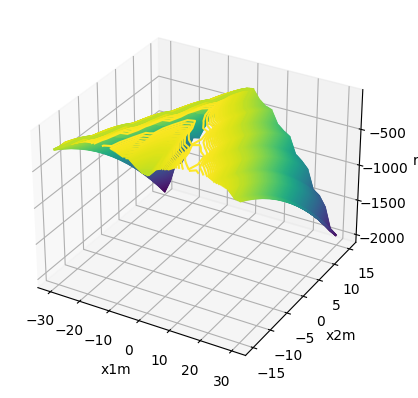

In [191]:
X1m , X2m = np.meshgrid(X1, X2)
R = Reward(X1m, X2m)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1m, X2m, R, 500, cmap='viridis')
ax.set_xlabel('x1m')
ax.set_ylabel('x2m')
ax.set_zlabel('r');

In [192]:
model = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(10, activation='softplus'),
    keras.layers.Dense(10, activation='softplus'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanSquaredError()],
)

x_train = np.array([[0,0]])
y_train = np.array([0])

for i in range(N1):
    for j in range(N2):
        x_train = np.append(x_train, [[i, j]], axis=0)
        y_train = np.append(y_train, policy[i, j])

x_train=  x_train[1:]
y_train=  y_train[1:]/U_BOUND

history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=100,
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                30        
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 1s 3ms/step - loss: 1.4319 - mean_squared_error: 1.4319
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.4206 - mean_squared_error: 1.4206
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 1.4080 - mean_squared_error: 1.4080

1/1 [==============================] - 0s 18ms/step


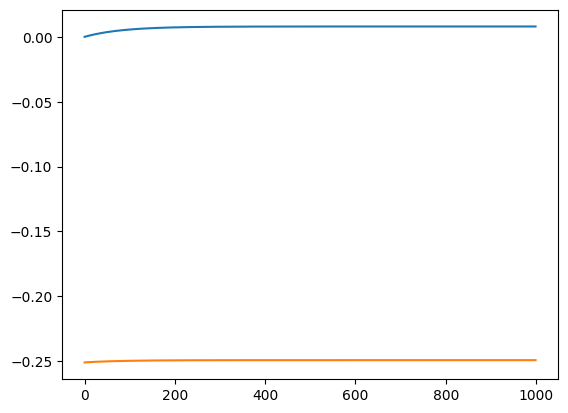

In [193]:
state = np.array([[0,0]])
rewards = []
x2 = []
for ep in range(1000):
    action = model.predict(state)
    dyndot = SingleLinkManipulator(state, action)
    state = state + dyndot*0.1
    rewards.append(Reward(state[0,0], state[0,1]))
    x2.append(state[0,0])

plt.plot(x2)
plt.plot(rewards)
